# 7.3 MLP on bank marketing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from Dataset import Dataset
from utils import get_splits

# Model training

In [2]:
df = pd.read_csv('data/bank-full.csv', header=0,sep=";")

In [3]:
df = df.drop(['month','day','duration'], axis=1)

In [4]:
df = pd.get_dummies(df,drop_first=True)

In [5]:
X = df.drop(['y_yes'], axis=1)
y = df['y_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
mlp = MLPClassifier(hidden_layer_sizes=(100,75), random_state=0)

In [7]:
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 75), random_state=0)

In [8]:
probs = mlp.predict_proba(X_test)

In [9]:
mlp.score(X_test, y_test)

0.8887496313771749

In [10]:
df_test = pd.DataFrame(X_test)
df_test['actual'] = y_test

In [11]:
df_test[['prob_0','prob_1']] = probs

In [12]:
df_test['pred'] = df_test['prob_1'].apply(lambda x: 0 if x<0.5 else 1)

# Calibration analysis

In [79]:
df = pd.read_csv('data/bank_out.csv', index_col=0)
var='Age'
df[var] = df['age']
df = Dataset(df, cal_size=1000)

## Uncalibrated

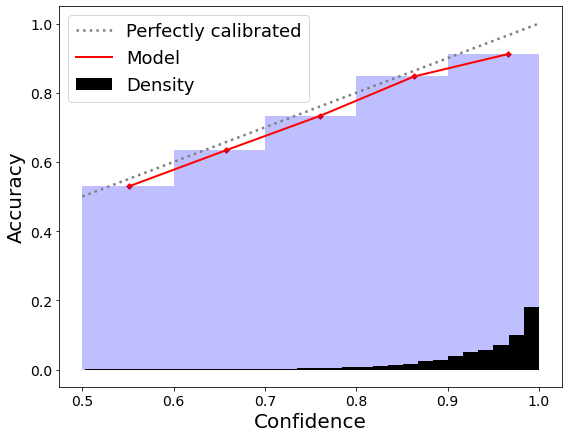

In [48]:
df.reliability_diagram(hist_weight=0.00005, filename="figs/bank_uncal_reliability.png")

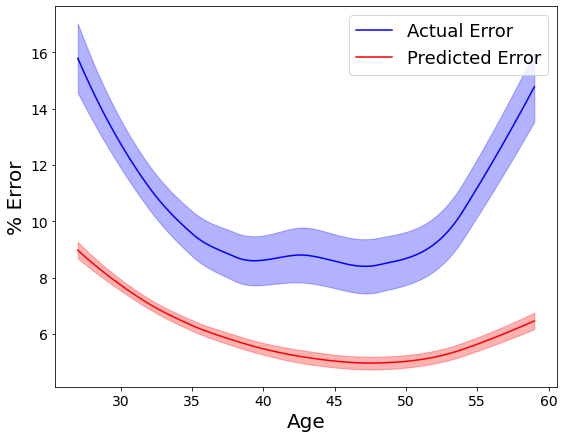

In [49]:
ylim = df.gen_plot_lowess(var=var,s=0.9, filename="figs/bank_uncal_errdiff.png")

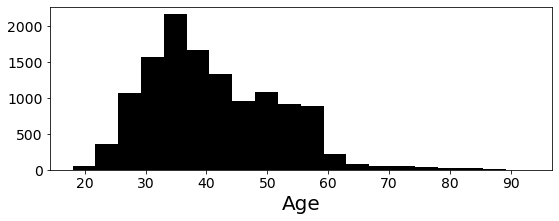

In [50]:
f, ax1 = plt.subplots(1, 1, figsize=(9,3))
ax1.hist(df.df[var], bins=20, color='black')
ax1.set_xlabel("Age", fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
plt.savefig('figs/bank_hist.png',bbox_inches="tight")
plt.show()

## Scaling-binning-calibrated

In [51]:
cont = ['age','balance']

In [52]:
for col in cont:
    print(col)
    print(df.compute_VECE(col, label="_kumar"))

age
0.03387231768926993
balance
0.03950714791354656


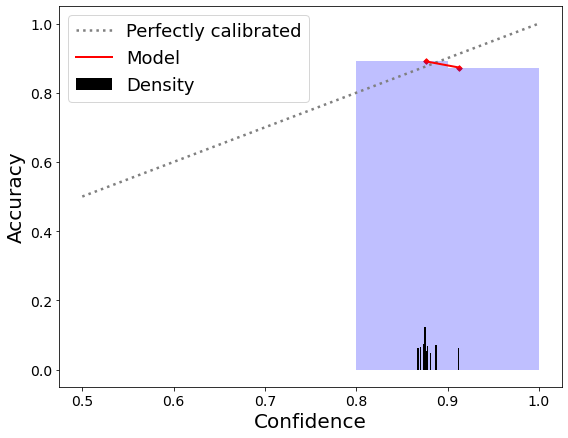

In [53]:
df.reliability_diagram(label="_kumar", hist_weight=0.00005, filename="figs/bank_kumar_reliability.png")

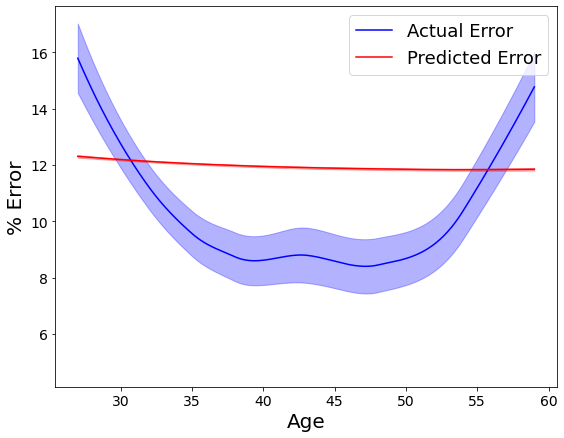

In [54]:
df.gen_plot_lowess(var=var, label='_kumar', use_lim=True, ylim=ylim,s=0.9, filename="figs/bank_kumar_errdiff.png")

## Variable-wise calibrated

In [80]:
splits = get_splits(df.df_cal[[var]], df.df[[var]], df.df_cal['actual'], df.df['actual'],
                    min_samples_leaf=int(len(df.df_cal)/20))

In [81]:
df.split_calibrate(var, splits, how='beta')

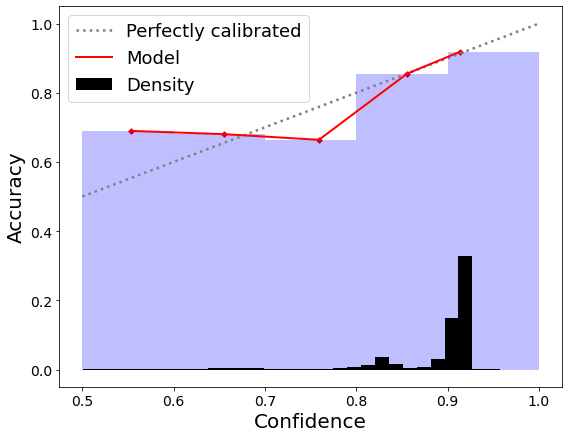

In [82]:
df.reliability_diagram(label="_split", hist_weight=0.00005, filename="figs/bank_split_reliability.png")

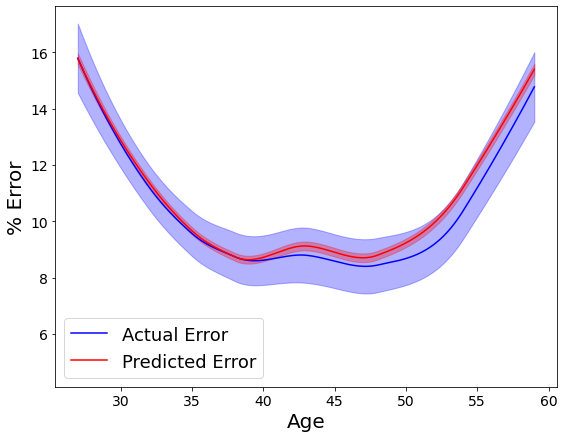

In [83]:
df.gen_plot_lowess(var=var, label='_split', use_lim=True, ylim=ylim,s=0.9, filename="figs/bank_split_errdiff.png")

## Overall results

In [87]:
bins=10

In [88]:
print("uncalibrated ECE=",df.compute_ECE(num_bins=bins))
print("Kumar calibrated ECE=",df.compute_ECE(label="_kumar", num_bins=bins))
print("Logistic calibrated ECE=", df.compute_ECE(label="_log", num_bins=bins))
print("Beta calibrated ECE=", df.compute_ECE(label="_beta", num_bins=bins))
print("Variable-wise calibrated ECE=",df.compute_ECE(label="_split", num_bins=bins))

uncalibrated ECE= 0.04693462497601752
Kumar calibrated ECE= 0.04368286591199143
Logistic calibrated ECE= 0.023803035745549178
Beta calibrated ECE= 0.024817942321657908
Variable-wise calibrated ECE= 0.020990727411351853


In [89]:
print("uncalibrated VECE =",df.compute_VECE(var=var, num_bins=bins))
print("Kumar calibrated VECE =",df.compute_VECE(label="_kumar",var=var, num_bins=bins))
print("Logistic calibrated VECE =",df.compute_VECE(label="_log",var=var, num_bins=bins))
print("Beta calibrated VECE =",df.compute_VECE(label="_beta",var=var, num_bins=bins))
print("Variable-wise calibrated VECE =",df.compute_VECE(label="_split",var=var, num_bins=bins))

uncalibrated VECE = 0.0469346249760175
Kumar calibrated VECE = 0.03387231768926998
Logistic calibrated VECE = 0.028295085861533762
Beta calibrated VECE = 0.02771482117480024
Variable-wise calibrated VECE = 0.005239158060853571


In [90]:
for col in cont:
    print(col)
    print("uncalibrated", df.compute_VECE(col))
    print("kumar", df.compute_VECE(col, label="_kumar"))
    print("variable-wise", df.compute_VECE(col, label="_split"))
    print()

age
uncalibrated 0.0469346249760175
kumar 0.03387231768926998
variable-wise 0.005239158060853571

balance
uncalibrated 0.05351020704242146
kumar 0.03950714791354659
variable-wise 0.032180636115586844

